In [2]:
import numpy as np
import pandas as pd


from scipy.stats import norm
from scipy.io import loadmat

from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.stats import norm
import multiprocessing as mp
from scipy.fft import fft, ifft, fftshift,ifftshift
from scipy.signal import fftconvolve

import matplotlib

from scipy.signal import sosfilt, butter

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

# Setup

In [4]:
time_min=-3
time_max=3
nx = 500000

time =np.arange(time_min,time_max,(time_max-time_min)/(nx-1))

currents = np.linspace(10,500,10) # Stimulus amplitudes

tIndex = np.intersect1d(np.where(time*1e3>0),np.where(time*1e3<10))

iteration = 0 # Irrelelevant since there is only one iteration


In [5]:
def getDiameters():
    
   
    minDiam = .1
    maxDiam = 15
    
    d = np.linspace(minDiam,maxDiam,2000)*1e-6

    return d

d = getDiameters()  

# Neural data figure

## Fiber velocities

### Myelinated

In [6]:
def getVelocitiesM(diameter,t1,t2,s1,s2):
    
    internodeDistance = 10 * diameter # in um
    
    numSections = s2-s1
    
    time = t2-t1 # in ms
    
    distance = (1 + internodeDistance) * numSections * 1e-6 # in m. Add 1 to account for node length
    
    v = distance / (time * 1e-3) # in m/s
    
    return v

In [7]:
v20 = getVelocitiesM(20,1.005,1.2275,42,52)
v10 = getVelocitiesM(10,0.9825,1.20625,42,52)
v5 = getVelocitiesM(5,0.9475,1.165,42,52)
v2 = getVelocitiesM(2,0.8725,1.0775,42,52)

diamsM = np.array([2,5,10,20])
vM = np.array([v2,v5,v10,v20])

### Unmyelinated

In [8]:
def getVelocities(t1,t2,s1,s2):
    
    sectionLength = 50 # in um
    
    numSections = s2-s1
    
    time = t2-t1 # in ms
    
    distance = sectionLength * numSections * 1e-6 # in m
    
    v = distance / (time * 1e-3) # in m/s
    
    return v

In [9]:
vp8 = getVelocities(10.1125,11.3,85,95)
vp4 = getVelocities(14.755,16.5175,85,95)
vp2 = getVelocities(22.387501,25.0625,85,95)
vp3 = getVelocities(17.455,19.537498,85,95)
vp6 = getVelocities(11.7975,13.1925,85,95)

diamsU = np.array([0.2,0.3,0.4,0.6,0.8])
vU = np.array([vp2,vp3,vp4,vp6,vp8])

## AP shape

In [10]:
def FitAPShape(ap,tphi): # Interpolates AP shape for a given AP
    
    
    # Ignores initial transient
    tv = ap.iloc[50:,0]
    v = ap.iloc[50:,1]
    
    ### Sets peak time to 0
    peak = tv[np.argmax(v)]
    tv -= peak


    apShapeEmpirical = v.values
        

    func = interp1d(tv,apShapeEmpirical,bounds_error=False,fill_value=(apShapeEmpirical[0],apShapeEmpirical[-1]))
    
    Vs = func(tphi)  
    
    
    #### Applies low-pass filter with very high cutoff, to remove artifacts
    sos = butter(1, 20000, 'lp', fs=83333, output='sos')
    
    V = sosfilt(sos,Vs)
    
    V[:10] = V[10]
         
    return V

### Myelinated

In [11]:
ap = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShape20.xlsx') # Rat
fitap = FitAPShape(ap,time)


### Unmyelinated

In [12]:
apU = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShapePoint8.xlsx') # Rat
fitapU = FitAPShape(apU,time)


## Thresholds

### Myelinated

In [13]:
thresholds = np.array([8.0625,3.40625,2.23438,1.71875,1.45313,1.28906,1.17188,1.03906,0.945313])
diameters = np.array([1,2,3,4,5,6,7,8,9])

thresholds *= 178


### Unmyelinated

In [14]:
thresholdsU = np.array([552,280,189,143,116,97,84,74,66.5])
diametersU = np.array([1,2,3,4,5,6,7,8,9])*0.1

thresholdsU *= 178


## Plots everything

<IPython.core.display.Javascript object>


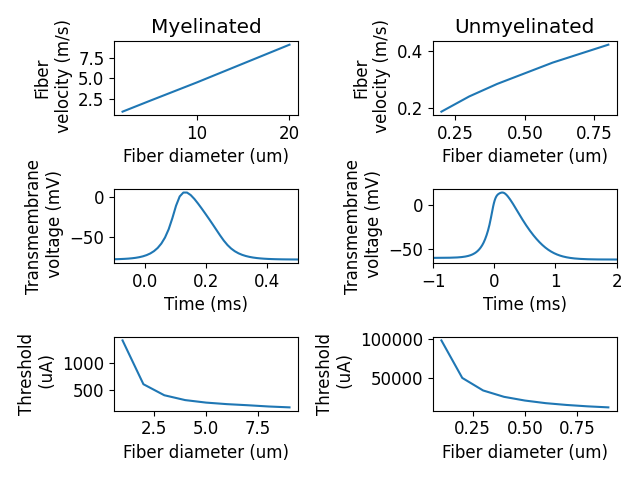

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [15]:
plt.figure()

plt.subplot(3,2,1) # velocity, myelinated

plt.title('Myelinated')

plt.plot(diamsM,vM,'-')
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Fiber\n velocity (m/s)')

plt.tight_layout()

plt.subplot(3,2,2) # Velocity, unmyelinated

plt.title('Unmyelinated')

plt.plot(diamsU,vU,'-')
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Fiber\n velocity (m/s)')


plt.tight_layout()

plt.subplot(3,2,3) # AP shape, myelinated

plt.plot(time*1e3, fitap*1e3)

plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane\n voltage (mV)')

plt.xlim([-.1,.5])

plt.tight_layout()

plt.subplot(3,2,4) # AP shape, unmyelinated

plt.plot(time*1e3, fitapU*1e3)

plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane\n voltage (mV)')

plt.xlim([-1,2])

plt.tight_layout()

plt.subplot(3,2,5) # Threshold, myelinated

plt.plot(diameters,thresholds)

plt.xlabel('Fiber diameter (um)')
plt.ylabel('Threshold\n (uA)')

plt.tight_layout()

plt.subplot(3,2,6) # Threshold, unmyelinated

plt.plot(diametersU,thresholdsU)

plt.xlabel('Fiber diameter (um)')
plt.ylabel('Threshold\n (uA)')

plt.tight_layout()


# Fiber type diameter distributions

In [5]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_senn_newRec/'

dist = []
for i in range(39):
    dist.append(np.load(outputfolder+'/'+str(iteration)+'/fascicles/probDist'+str(i)+'.npy',allow_pickle=True))
    

<IPython.core.display.Javascript object>


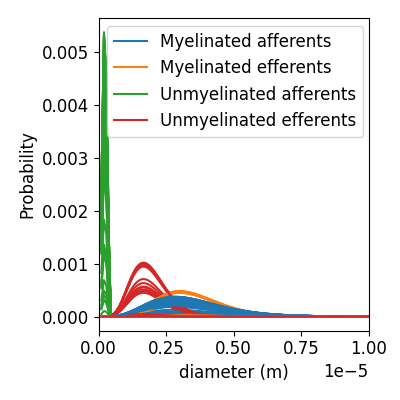

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [6]:
plt.figure(figsize=(4,4))

for i in range(39):
    plt.plot(d,dist[i][0],c='tab:blue')
    plt.plot(d,dist[i][1],c='tab:orange')
    plt.plot(d,dist[i][2],c='tab:green')
    plt.plot(d,dist[i][3],c='tab:red')

plt.legend(['Myelinated afferents','Myelinated efferents','Unmyelinated afferents','Unmyelinated efferents'])
plt.xlim([0,1e-5])
plt.xlabel('diameter (m)')
plt.ylabel('Probability')
plt.tight_layout()

# Signal as a function of stimulus amplitude

### Horizontal electrode, high perineuria conductivity, large separation between recording electrodes, 6 cm from stimulus to recording electrode

In [5]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_senn_newRec/'

distanceIdx = 0 # 6 cm

maffAll = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    maffAll = np.vstack((maffAll,np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))
    
meffAll = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    meffAll = np.vstack((meffAll,np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

uaffAll = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    uaffAll = np.vstack((uaffAll,np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

ueffAll = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(0)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    ueffAll = np.vstack((ueffAll,np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(0)+'/signals_'+str(i)+'.npy')[np.newaxis]))

totalAll = maffAll + meffAll+ uaffAll + ueffAll



In [6]:
signals = np.sum(totalAll,axis=0)

In [9]:
recruitment = []
for i in range(39):
    recruitment.append(np.load(outputfolder+'/'+str(iteration)+'/recruitment/recruitment_'+str(i)+'.npy',allow_pickle=True))
    

<IPython.core.display.Javascript object>


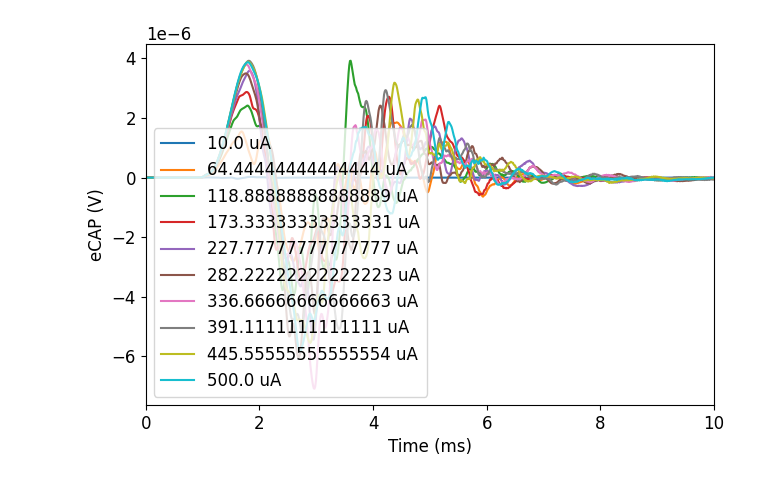

/gpfs/bbp.cscs.ch/home/tharayil/bluepy-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app


In [38]:
plt.figure(figsize=(4,4))

legend = []

for i in range(10):
    
    plt.plot(time[1:-1]*1e3,signals[i])
    legend.append(str(currents[i])+' uA')
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([0,10])
plt.tight_layout()


In [11]:
np.linspace(10,500,50)

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140., 150., 160., 170., 180., 190., 200., 210., 220.,
       230., 240., 250., 260., 270., 280., 290., 300., 310., 320., 330.,
       340., 350., 360., 370., 380., 390., 400., 410., 420., 430., 440.,
       450., 460., 470., 480., 490., 500.])

# Peak-to-peak signal amplitude as function of stimulus amplitude

### Same parameters as above

In [12]:
amplitudes = np.max(signals[:,tIndex],axis=1)-np.min(signals[:,tIndex],axis=1)

<IPython.core.display.Javascript object>


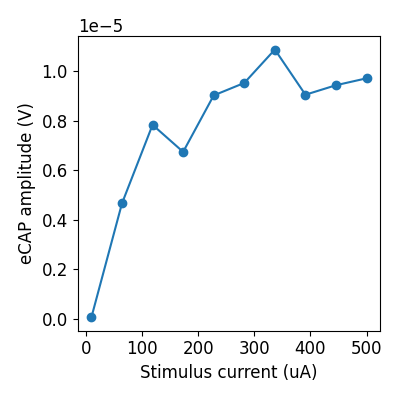

In [39]:
plt.figure(figsize=(4,4))

plt.plot(currents,amplitudes,'-o')

plt.xlabel('Stimulus current (uA)')
plt.ylabel('eCAP amplitude (V)')

plt.tight_layout()

# Correlations between different fascicles
### Same recording parameters as above
### 500 uA stimulus current

In [14]:
from sklearn.cluster import SpectralCoclustering 

In [15]:
normalizedSignals = totalAll[:,-1,tIndex]/np.mean(np.sqrt(totalAll[:,-1,tIndex]**2),axis=0)


In [16]:
normalizedSignals.shape

(39, 833)

In [17]:
correlations = np.corrcoef(totalAll[:,-1,:])

correlations = np.corrcoef(normalizedSignals)



In [18]:
model = SpectralCoclustering(n_clusters=4, random_state=0)
model.fit(correlations)

SpectralCoclustering(n_clusters=4, random_state=0)

In [19]:
fit_data = correlations[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

<IPython.core.display.Javascript object>


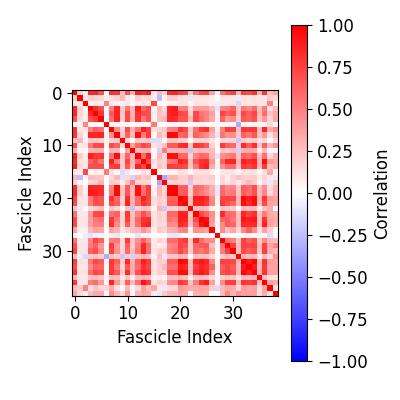

In [40]:
fig, ax = plt.subplots(figsize=(4,4))

plot = plt.imshow(correlations, cmap=plt.cm.bwr,vmin=-1,vmax=1)

fig.colorbar(plot, label='Correlation')
plt.xlabel('Fascicle Index')
plt.ylabel('Fascicle Index')
plt.tight_layout()

<IPython.core.display.Javascript object>


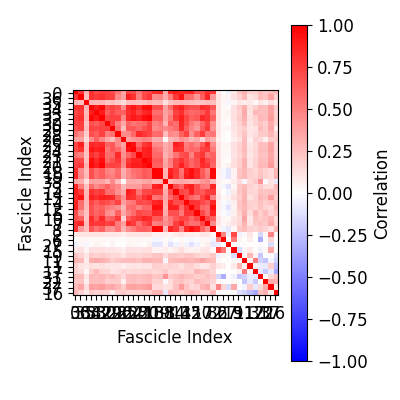

/gpfs/bbp.cscs.ch/home/tharayil/bluepy-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  


In [41]:
fig, ax = plt.subplots(figsize=(4,4))

plt.imshow(fit_data, cmap=plt.cm.bwr,vmin=-1,vmax=1,interpolation='None')

plt.xticks(np.arange(39),np.argsort(model.row_labels_))
plt.yticks(np.arange(39),np.argsort(model.row_labels_))

fig.colorbar(plot, label='Correlation')
plt.xlabel('Fascicle Index')
plt.ylabel('Fascicle Index')
plt.tight_layout()

<IPython.core.display.Javascript object>


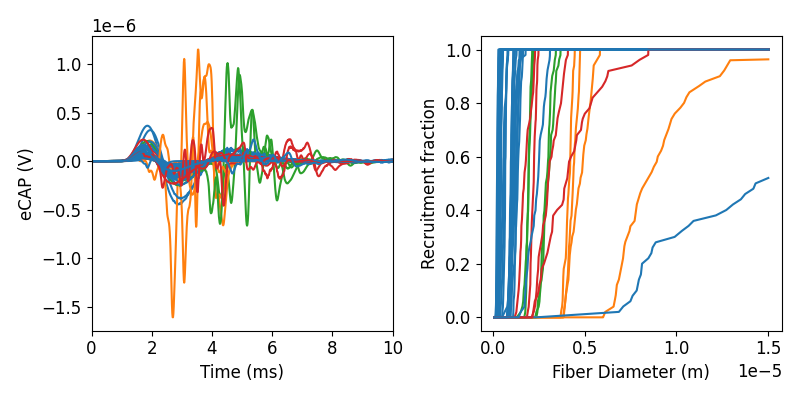

In [42]:
plt.figure(figsize=(8,4))

for i in range(39):
    
    plt.subplot(1,2,1)
    
    plt.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.row_labels_[i]))

    plt.xlabel('Time (ms)')
    plt.ylabel('eCAP (V)')

    plt.xlim([0,10])
    
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(d,recruitment[i][-1][0],c='C'+str(model.row_labels_[i]))
    
    plt.xlabel('Fiber Diameter (m)')
    plt.ylabel('Recruitment fraction')
    plt.tight_layout()

<IPython.core.display.Javascript object>


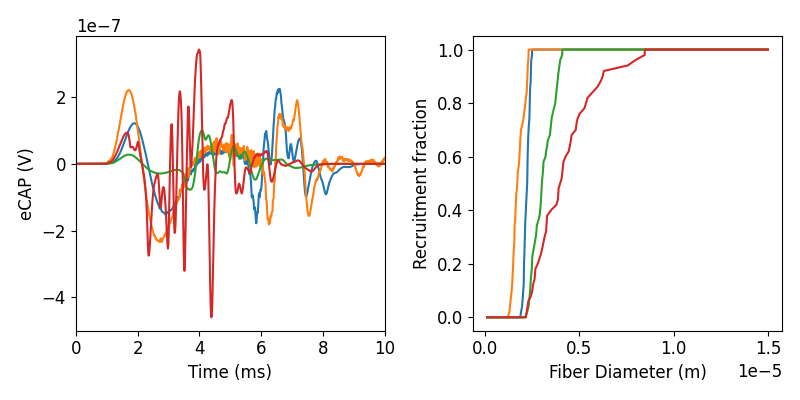

In [43]:
plt.figure(figsize=(8,4))

for i in range(39):
    
    if model.row_labels_[i]==3:

        plt.subplot(1,2,1)


        plt.plot(time[1:-1]*1e3,totalAll[i,-1])

        plt.xlabel('Time (ms)')
        plt.ylabel('eCAP (V)')

        plt.xlim([0,10])

        plt.tight_layout()

        plt.subplot(1,2,2)
        plt.plot(d,recruitment[i][-1][0])

        plt.xlabel('Fiber Diameter (m)')
        plt.ylabel('Recruitment fraction')
        plt.tight_layout()

<IPython.core.display.Javascript object>


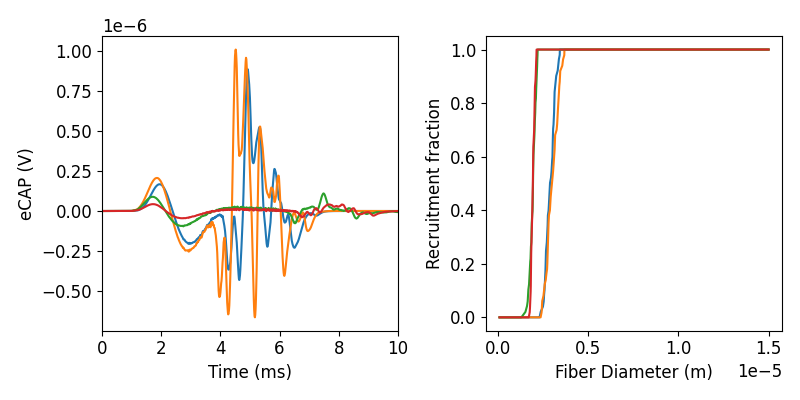

In [44]:
plt.figure(figsize=(8,4))

for i in range(39):
    
    if model.row_labels_[i]==2:

        plt.subplot(1,2,1)


        plt.plot(time[1:-1]*1e3,totalAll[i,-1])

        plt.xlabel('Time (ms)')
        plt.ylabel('eCAP (V)')

        plt.xlim([0,10])

        plt.tight_layout()

        plt.subplot(1,2,2)
        plt.plot(d,recruitment[i][-1][0])

        plt.xlabel('Fiber Diameter (m)')
        plt.ylabel('Recruitment fraction')
        plt.tight_layout()

<IPython.core.display.Javascript object>


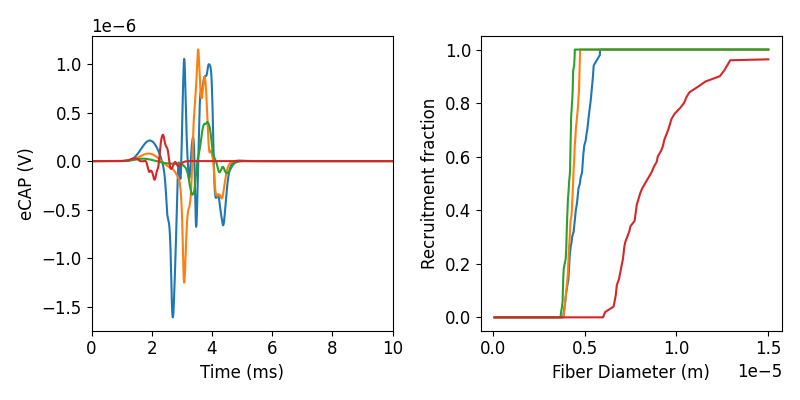

In [45]:
plt.figure(figsize=(8,4))

for i in range(39):
    
    if model.row_labels_[i]==1:

        plt.subplot(1,2,1)


        plt.plot(time[1:-1]*1e3,totalAll[i,-1])

        plt.xlabel('Time (ms)')
        plt.ylabel('eCAP (V)')

        plt.xlim([0,10])

        plt.tight_layout()

        plt.subplot(1,2,2)
        plt.plot(d,recruitment[i][-1][0])

        plt.xlabel('Fiber Diameter (m)')
        plt.ylabel('Recruitment fraction')
        plt.tight_layout()

# 1 cm distance between stimulus and recording electrode
### Other parameters unchanged

In [46]:
distanceIdx = 2

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


In [27]:
total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

<IPython.core.display.Javascript object>


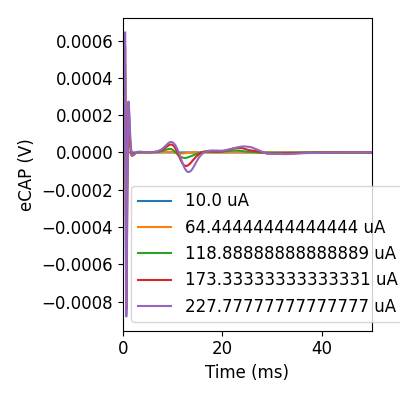

In [47]:
plt.figure(figsize=(4,4))

legend = []

for i in range(5):
    
    plt.plot(time[1:-1]*1e3,total1cm[i])
    legend.append(str(currents[i])+' uA')
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([0,50])
plt.tight_layout()


<IPython.core.display.Javascript object>


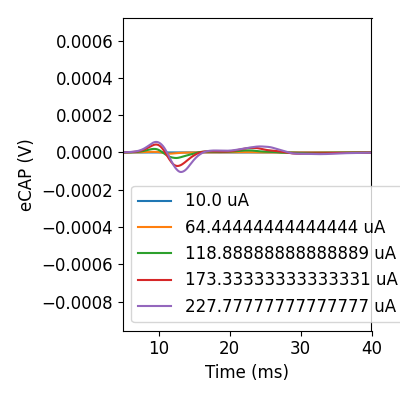

In [48]:
plt.figure(figsize=(4,4))

legend = []

for i in range(5):
    
    plt.plot(time[1:-1]*1e3,total1cm[i])
    legend.append(str(currents[i])+' uA')
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([5,40])
plt.tight_layout()


# Gaussian jitter in recruitment curve
### Random variable added to the recruitment threshold for each fiber in the S4L model, with mean 40% of the threshold
### 6 cm distance between stimulus and recording electrodes

In [7]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_senn_gaussian_large/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

In [8]:
np.linspace(10,40,5)

array([10. , 17.5, 25. , 32.5, 40. ])

<IPython.core.display.Javascript object>


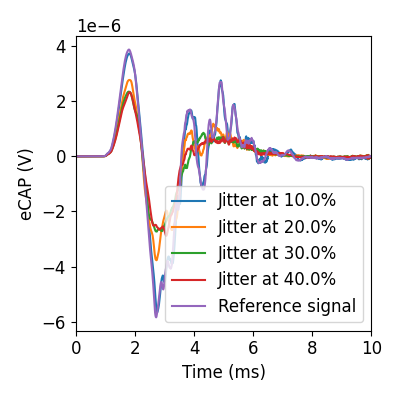

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [9]:
plt.figure(figsize=(4,4))

legend = []

jitters = np.linspace(10,40,4)

for i in range(4):
    plt.plot(time[1:-1]*1e3,total6cm[i])
    legend.append('Jitter at '+str(jitters[i]) +'%')
    
    
plt.plot(time[1:-1]*1e3,signals[-1])

legend.append('Reference signal')
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([0,10])
plt.tight_layout()


# Small cuff electrode covering only one side of the nerve
### 6 cm distance between stimulus and recording electrodes
### 12 mm separation between stimulus and recordign electrodes
### No gaussian jitter
### Signal plotted at 500 uA for both reference case and small electrode case

In [56]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_smallRec/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

<IPython.core.display.Javascript object>


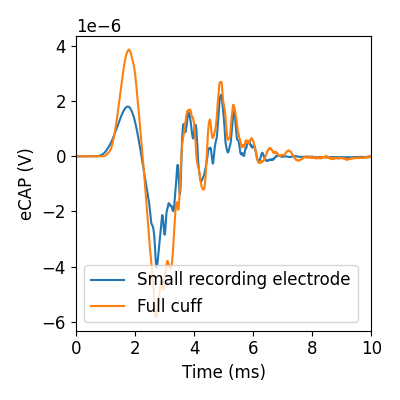

In [57]:
plt.figure(figsize=(4,4))


for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Small recording electrode','Full cuff'])

plt.xlim([0,10])
plt.tight_layout()

# Same as above, but for recording electrode on opposite side of nerve

In [7]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_smallRec_Otherside/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

<IPython.core.display.Javascript object>


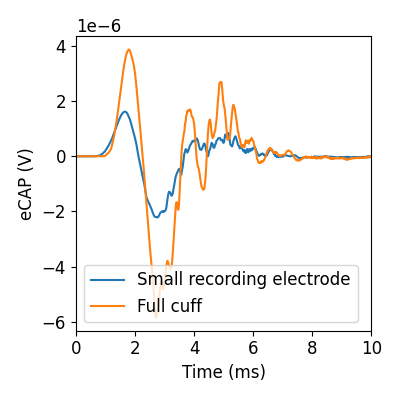

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [8]:
plt.figure(figsize=(4,4))


for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Small recording electrode','Full cuff'])

plt.xlim([0,10])
plt.tight_layout()

# 3 mm separation between recording electrodes instead of 12 mm
### No gaussian jitter
### 6 cm stimulus-recording separation

In [9]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_close/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm



<IPython.core.display.Javascript object>


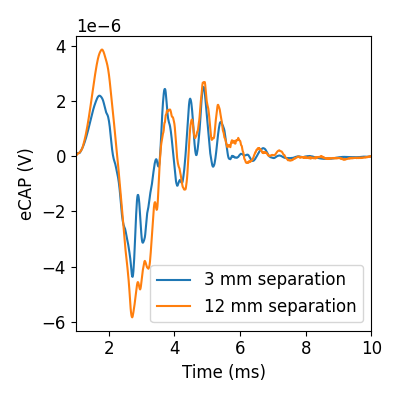

In [10]:
plt.figure(figsize=(4,4))

for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['3 mm separation','12 mm separation'])

plt.xlim([1,10])
plt.tight_layout()


# Monopolar recordings
### 12 mm distance between the two cuff electrodes
### No gaussian jitter

In [11]:
outputfolderM = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_monopolar/'

distanceIdx = 0

maffM = np.load(outputfolderM+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffM = np.load(outputfolderM+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffM = np.load(outputfolderM+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffM = np.load(outputfolderM+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalM = maffM + meffM + uaffM + ueffM

outputfolderMf = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_monopolar_far/'

maffMf = np.load(outputfolderMf+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffMf = np.load(outputfolderMf+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffMf = np.load(outputfolderMf+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffMf = np.load(outputfolderMf+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalMf = maffMf + meffMf + uaffMf + ueffMf



### Plot eCAPs at 500 uA stimulus current

<IPython.core.display.Javascript object>


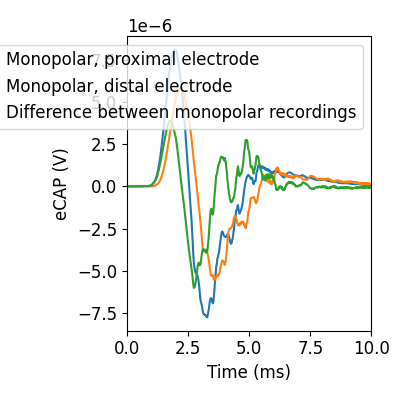

In [12]:
plt.figure(figsize=(4,4))

legend = ['Monopolar, proximal electrode','Monopolar, distal electrode','Difference between monopolar recordings']
    
plt.plot(time[1:-1]*1e3,totalM[-1])
plt.plot(time[1:-1]*1e3,totalMf[-1])
plt.plot(time[1:-1]*1e3,totalM[-1]-totalMf[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([0,10])
plt.tight_layout()

# Low perineurium conductivity
### 6 cm stimulus-recording separation
### 12 mm separation between cuff electrodes
### No gaussian jitter

In [13]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_senn_newRec_lowConductivity/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

<IPython.core.display.Javascript object>


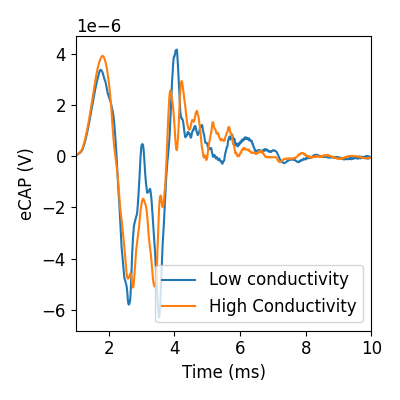

In [14]:
plt.figure(figsize=(4,4))

legend = []

for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-3])
    plt.plot(time[1:-1]*1e3,signals[-3])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Low conductivity','High Conductivity'])

plt.xlim([1,10])
plt.tight_layout()

# Vertical orientation of stimulation electrode
### High perineurium conductivity
### 12 mm separation between recording electrodes
### 6 cm separation between stimulus and recording electrodes

In [15]:
outputfolderD = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Analytic_allActive_squareTerm_senn_downward/'

distanceIdx = 0

maffD = np.load(outputfolderD+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffD = np.load(outputfolderD+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffD = np.load(outputfolderD+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffD = np.load(outputfolderD+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalD = maffD + meffD + uaffD + ueffD


<IPython.core.display.Javascript object>


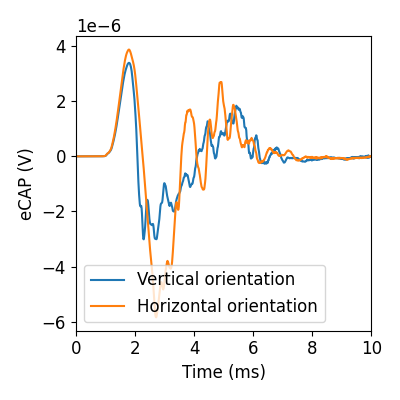

In [16]:
plt.figure(figsize=(4,4))

legend = []

for i in range(1):
    
    plt.plot(time[1:-1]*1e3,totalD[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Vertical orientation','Horizontal orientation'])

plt.xlim([0,10])
plt.tight_layout()